In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings(action='ignore')


    survival          생존 여부            0 = No, 1 = Yes

    pclass            선실 등급            1 = 1st, 2 = 2nd, 3 = 3rd

    sex               성별    

    Age               나이  

    sibsp             형재 자매의 수/ 배우자 등이 승선한 경우 수    

    parch             부모나 자식과 같이 탄 경우 수   

    ticket            표 번호    

    fare              요금

    cabin             선실 번호   

    embarked          승선한 항구         C = Cherbourg, Q = Queenstown, S = Southampton


******역사적 배경 1912년 미국 가는 배 ?


point . 나이 범주화 또는  mr , mrs , name 를 이용한 age 결측치 채우기 

2. (1,2,3 등 칸 )
3. 아이 우선 기준 13세 이하 ? -> 나이를 이용한 생존율 예측 -> linear regressioin
 - > age group heatmap


In [13]:
test_csv = pd.read_csv('/Users/chosunghyun/Desktop/Python.proj/kaggle/Titanic/test.csv')
train_csv = pd.read_csv('/Users/chosunghyun/Desktop/Python.proj/kaggle/Titanic/train.csv')

In [105]:
test_csv.info()
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass  

In [106]:
train_data = train_csv.copy()
test_data = test_csv.copy()

In [108]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [107]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [42]:
# 전제 조건  : 성별과 생존율 , 계급과 생존율은 연관이 있다.  -> 종속이다 독립이 아니다.

In [109]:
tddf = train_data[['Survived','Pclass']]

f = tddf.loc[(tddf['Pclass'] == 1)]
s = tddf.loc[(tddf['Pclass'] == 2)]
t = tddf.loc[(tddf['Pclass'] == 3)]

def survived(seriess):
    s =0
    d =0
    for x in seriess :
        if x == 1:
            s+=1
        else: d+=1

    result= s/(s+d)
    return result


print(survived(f.Survived),survived(s.Survived),survived(t.Survived))

# train data set first class 가 3배 높은 생존율을 보임


0.6296296296296297 0.47282608695652173 0.24236252545824846


In [114]:
#train_data['Sex'].isnull().sum()   :  0
train_data['Sex']

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [115]:
###  성별 생존율  ,결측치 없음
tddf = train_data[['Survived','Sex']]
f = tddf.loc[(tddf['Sex'] == 'female')]
m = tddf.loc[(tddf['Sex'] == 'male')]
print(survived(f.Survived),survived(m.Survived))

0.7420382165605095 0.18890814558058924


In [116]:
# 전제 조건 점검
# data  수 -> 중심극한 정리 n >30 정규성을 만족
# 상관 관계 파악
cor = train_data.corr()
cor

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [120]:
# traindata,testdata 의 NAN를 채운다 - >fare  -  class

In [121]:
trddf = train_data[['Pclass','Fare']]
teddf = test_data[['PassengerId','Pclass','Fare']]

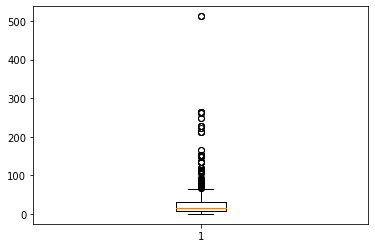

In [122]:
ax = plt.boxplot(train_data[['Fare']])
plt.show()

In [123]:
trddf['Fare'].max()

512.3292

In [124]:
f = trddf.loc[(trddf['Pclass'] == 1)]
s = trddf.loc[(trddf['Pclass'] == 2)]
t = trddf.loc[(trddf['Pclass'] == 3)]

In [125]:
print(len(f),len(s),len(t))

216 184 491


In [126]:
print(f.Fare.mean())
print(s.Fare.mean())
print(t.Fare.mean())

84.15468749999992
20.66218315217391
13.675550101832997


In [84]:
# 행 추출
teddf[teddf['Fare'].isnull()]

,PassengerId,Pclass,Fare
152,1044,3,NaN


In [132]:
# 결측치 처리 및 확인 
test_data.loc[(test_data['PassengerId']==1044),'Fare'] = 13 

In [134]:
teddf = test_data[['PassengerId','Pclass','Fare']]
teddf[teddf['Fare'].isnull()]

,PassengerId,Pclass,Fare


# Age - Name  - 생존율 ?


-> mr,miss,,,,etc


-> mean

-> SibSp,Parch

--> 어린 아이의 under 14 생존율이 높을듯,,하다!     -> same cabin ?

In [143]:
train_data.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [179]:
trdf = train_data[['Age','Survived']]
# 나이 평균으로 결측 채우기
meanAge = trdf.Age.mean()
meanAge = round(meanAge,3)
meanAge

29.699

In [176]:
trdf=trdf.Age.fillna(meanAge)     

In [182]:
trdf.isnull().sum()

Age         177
Survived      0
dtype: int64

In [142]:
# name  ? 
trname = train_data.Name
trname

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [164]:
temp = data.copy()
temp['Initial'] = 0
temp['Initial'] = train_data.Name.str.extract('([A-Za-z0-9]+)\.')

NameError: name 'temp' is not defined